In [167]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm

import os
import re

os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric PDE

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  k(x,\theta) = 
\begin{cases}
  0 &\text{if } x\in \left[0,\frac{1}{4} \right) \\
  \theta_{1} &\text{if } x\in \left[\frac{1}{4},\frac{1}{2}\right) \\
  \theta_{2} &\text{if } x\in \left[\frac{1}{2},\frac{3}{4}\right) \\
  1 &\text{if } x\in \left[\frac{3}{4},1\right] \\
\end{cases}
        
$$

## The Problem consist in infering $ \alpha $

Text(0, 0.5, 'Observations')

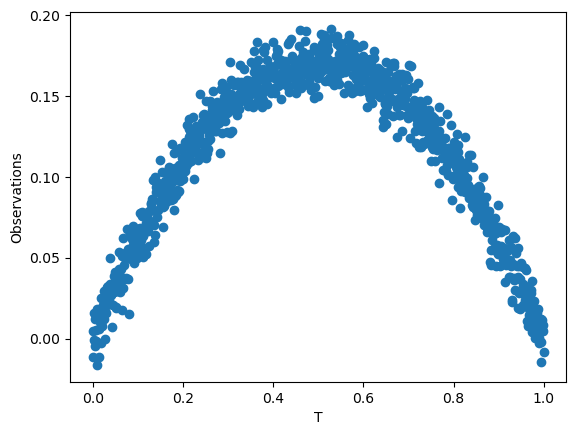

In [168]:
ns = 1
t= np.linspace(0,ns,1000)
mean, std = 0,np.sqrt(1e-4)

Exact = (t - t**2) / 2*np.exp(0.314)

noise_sol = Exact + np.random.normal(mean,std, len(t))

plt.scatter(t,noise_sol)
plt.xlabel("T")
plt.ylabel("Observations")

## Feed Forward Neural Network

In [169]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [170]:
def DE(self,t,pr1,pr2):
    """ The pytorch autograd version of calculating residual """

    u = self(torch.cat([t, pr1,pr2], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t, 
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]

    pr = torch.zeros_like(t)

    pr = torch.where((t >= 1/4.)& (t < 3/4.),pr1,pr)
    #pr = torch.where((t >= 1/4.) & (t < 1/2.),pr1,pr)
    #pr = torch.where((t >= 1/2.) & (t < 3/4.),pr2,pr)
    pr = torch.where((t >= 3/4.) & (t <= 1),1,pr)

    f = -torch.exp(pr)*u_tt - 4*t
    return f 

In [171]:
DNN.DE = DE

In [172]:
def sample_ic(size):
    return np.zeros(size)

def sample_bc(size):
    return np.ones(size)

def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

# def samples_param(min,max,size = 100):
#     return min + np.random.rand(size)*(max - min)

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [173]:
def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
   print("Starting Training")

   #for epoch in range(epochs):
   itr_loss = 0.0   

   for i in range(epochs):

    ic,bc, t, param1,param2 = sample_ic(size),sample_bc(size),samples_space(size,maxl),samples_param(minp,maxp,size),samples_param(minp,maxp,size)

    ic, bc, t = torch.tensor(ic).float().to(device),torch.tensor(bc).float().to(device), torch.tensor(t).float().to(device)
    param1, param2 = torch.tensor(param1).float().to(device), torch.tensor(param2).float().to(device)

    ic, bc ,t = Variable(ic,requires_grad=True).reshape(-1,1),Variable(bc,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1)
    param1,param2 =  Variable(param1,requires_grad=True).reshape(-1,1),Variable(param2,requires_grad=True).reshape(-1,1)

       
    def loss_func_train():
        
        optimizer.zero_grad()

        ic_pred,bc_pred,f_pred = pinn(torch.cat([ic, param1, param2], dim=1)), pinn(torch.cat([bc, param1,param2], dim=1)),pinn.DE(t,param1,param2)

        loss_u_ic,loss_u_bc,loss_f = loss(ic_pred,torch.zeros_like(t)),loss(bc_pred,torch.ones_like(t)*2),loss(f_pred,torch.zeros_like(t))

        Loss =  loss_f + loss_u_ic + loss_u_bc

        if i % 10 == 0:
                print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e' % (i, Loss.item(), loss_u_ic.item(), loss_f.item()))
           
        Loss.backward() 
    
        return Loss

    optimizer.step(loss_func_train) 
    
    oupt = pinn(torch.cat([ic, param1,param2], dim=1))  

    loss_val = loss_func_train() 

    itr_loss += loss_val.item()  

In [174]:
# Number of observations
epochs = 10
nobs = 1500
lr = 0.1

min_param , max_param = -1, 1

space = 1

layers = [3] + 2*[30] + [1]

In [175]:
np.random.uniform(-1, 1, 10)


array([-0.19850266, -0.19384915, -0.49342606,  0.0136769 , -0.63087968,
       -0.88583195, -0.26614692,  0.43967457, -0.05165093,  0.84524056])

In [176]:
model = DNN(layers)

In [177]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

#optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [178]:
train(epochs, model,loss,optimizer,nobs,space,min_param , max_param)

# model.load_state_dict(torch.load("Param_model_T2.pt"))
# model.eval()

Starting Training
Iter 0, Loss: 8.76142e+00, Loss_ic: 4.40716e-02, Loss_f: 5.37389e+00
Iter 0, Loss: 8.71156e+00, Loss_ic: 4.62266e-02, Loss_f: 5.35849e+00
Iter 0, Loss: 8.27775e+00, Loss_ic: 6.82479e-02, Loss_f: 5.22329e+00
Iter 0, Loss: 5.35347e+00, Loss_ic: 5.47758e-01, Loss_f: 4.10390e+00
Iter 0, Loss: 4.91968e+00, Loss_ic: 6.25903e-01, Loss_f: 3.81564e+00
Iter 0, Loss: 3.26703e+00, Loss_ic: 1.57932e+00, Loss_f: 1.22760e+00
Iter 0, Loss: 3.04416e+00, Loss_ic: 1.43839e+00, Loss_f: 1.17747e+00
Iter 0, Loss: 1.59288e+00, Loss_ic: 4.92763e-01, Loss_f: 8.95683e-01
Iter 0, Loss: 1.46767e+00, Loss_ic: 4.16012e-01, Loss_f: 8.91086e-01
Iter 0, Loss: 1.31298e+00, Loss_ic: 3.21369e-01, Loss_f: 8.52439e-01
Iter 0, Loss: 1.16875e+00, Loss_ic: 2.44811e-01, Loss_f: 8.26369e-01
Iter 0, Loss: 1.06056e+00, Loss_ic: 1.88730e-01, Loss_f: 7.95477e-01
Iter 0, Loss: 9.63653e-01, Loss_ic: 1.42423e-01, Loss_f: 7.63231e-01
Iter 0, Loss: 6.04731e-01, Loss_ic: 1.36989e-02, Loss_f: 5.79001e-01
Iter 0, Loss: 5.

In [69]:
torch.save(model.state_dict(),"Param_model_T2.pt")

In [137]:
def test_set(max_space,obs,param,mean,std):

    t = np.linspace(0,max_space,obs)

    sol = (t - t**2) / (2*np.exp(param))

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

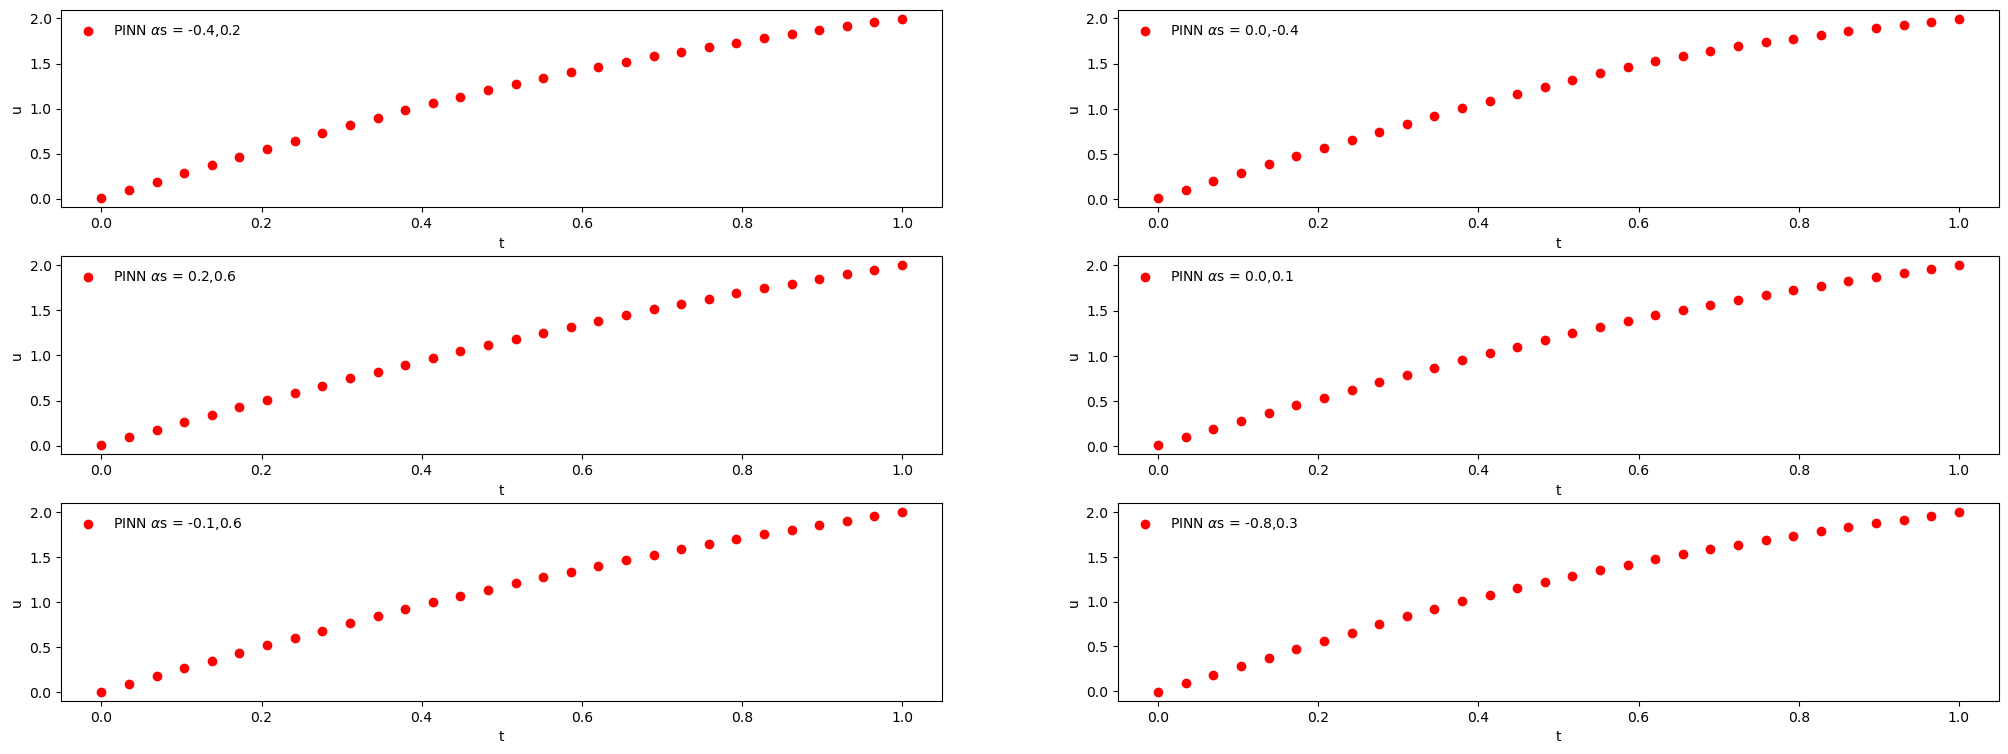

In [159]:
import matplotlib.pyplot as plt
from matplotlib import cm


param_trained =  samples_param(min_param , max_param,6)
param_trained2 =  samples_param(min_param , max_param,6)


# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)

for n,(pr1,pr2) in enumerate(zip(param_trained,param_trained2)):

    t, noise_sol_test = test_set(ns,30,pr1,mean,std)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr1), np.ones_like(t).flatten()[:,None]*(pr2)))

    u_pred = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    plt.subplot(8, 2, n + 1)

    plt.scatter(t, u_pred, label = fr"PINN $\alpha$s = {pr1:.1f},{pr2:.1f}", color = "red")

    #plt.scatter(t,-(2/3)*t**3 + 2.5*t, label = "Observations",color= "blue",alpha = 0.5)

    plt.xlabel("t")
    plt.ylabel("u")
    plt.legend(frameon=False)

## MCMC Step

In [160]:
def log_prior_alpha(pr1,pr2): #function to evaluate prior pdf of given parameters
    #return norm.logpdf(pr1,loc = 0,scale = 1.5) + norm.logpdf(pr2,loc = 0,scale = 1.5)
    return uniform(loc = -1, scale = 2).logpdf(pr1) + uniform(loc = -1, scale = 2).logpdf(pr2)

def proposals(alpha,dt):
    return np.random.normal(alpha,dt)

In [122]:
def log_likelihood(surrogate,pr1,pr2,t,y_dat,sig = std):
    
    data_ =  np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr1), np.ones_like(t).flatten()[:,None]*(pr2)))

    surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

In [123]:
def log_posterior_nn(model,pr1,pr2,t,y):
    return  log_likelihood(model,pr1,pr2,t,y) + log_prior_alpha(pr1,pr2)

In [179]:
# Number of spatial oberservation points
dy = 6

t = np.array([0] + list(np.linspace(0.2,0.8,dy)) + [1])

noise_sol_test = np.array([0,6.365626160107796805e-01,9.853532348454457912e-01,
                           1.302974414932300373e+00,1.556834710607004846e+00,1.747096483481726858e+00,1.883543121727832892e+00,2])

theta_true = [0.0976270078546495, 0.43037873274483895]

data_ =  np.hstack([t.reshape(-1,1), np.ones_like(t).reshape(-1,1)*(.0976270078546495), np.ones_like(t).reshape(-1,1)*(.43037873274483895)])

nn = model(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
    

In [180]:
nn

array([-0.00241643,  0.5039708 ,  0.7951028 ,  1.069453  ,  1.3206937 ,
        1.542248  ,  1.7302663 ,  1.9982805 ], dtype=float32)

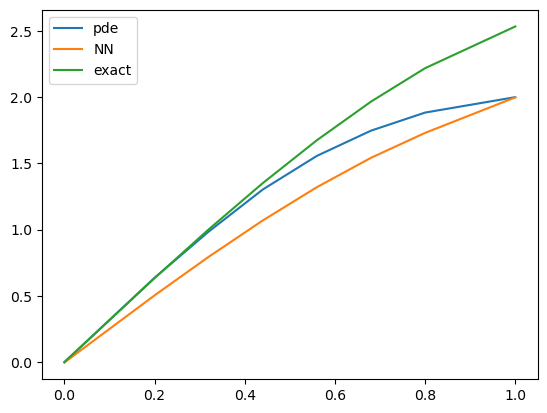

In [181]:
plt.plot(t,noise_sol_test,label ="pde")
plt.plot(t,nn,label = "NN")
plt.plot(t,(-2/3)*t**3 + 3.2*t ,label = "exact")

plt.legend()

In [94]:
alpha_1 = np.linspace(-1,1,50)
alpha_2 = np.linspace(-1,1,50)

alpha_fc_nn = []


for alp1 in alpha_1:
    for alp2 in alpha_2:    
        alpha_fc_nn.append(log_posterior_nn(model,alp1,alp2,t,noise_sol_test))

In [95]:
X, Y = np.meshgrid(alpha_1, alpha_2)
Z = np.array(alpha_fc_nn).reshape(X.shape)
Z2 = np.array(4000*np.exp(alpha_fc_nn)/np.sum(np.exp(alpha_fc_nn))).reshape(X.shape)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


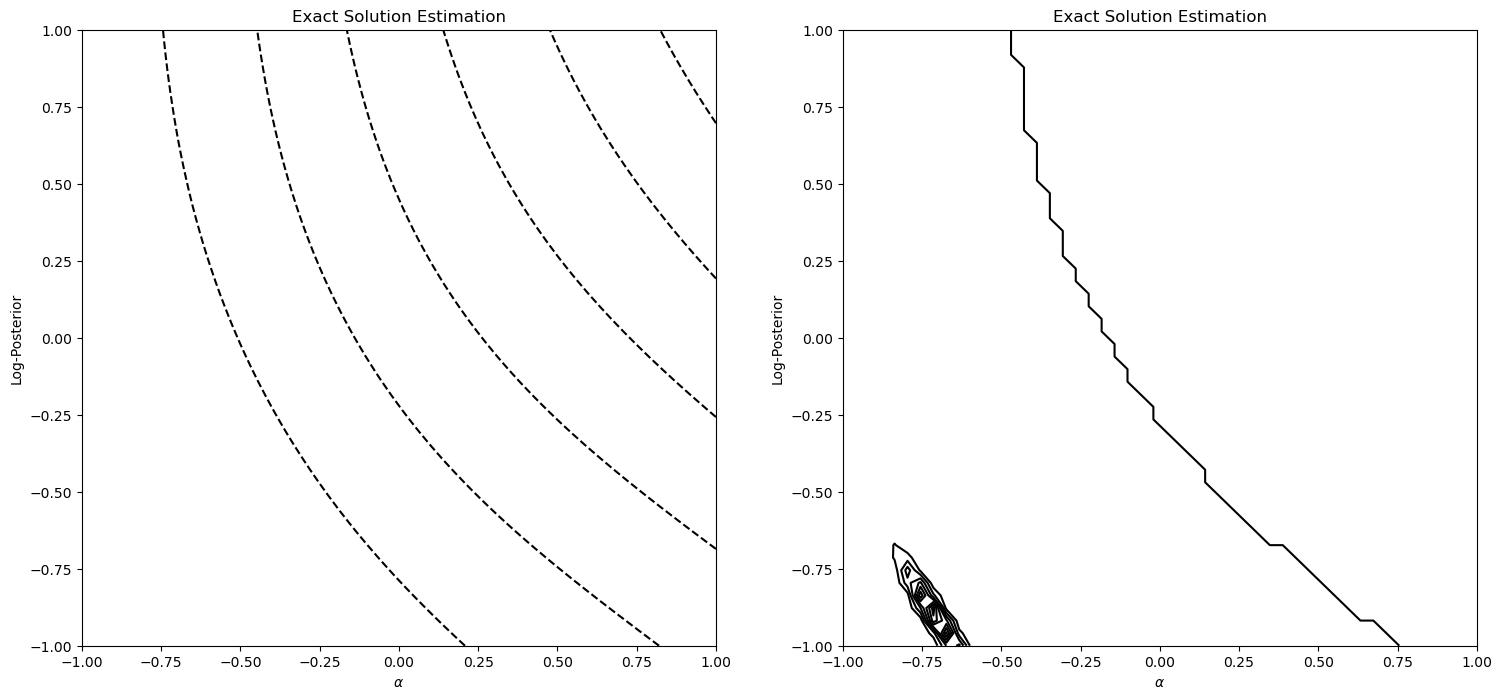

In [96]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=0.25)

plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, colors='black')
#plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)


plt.subplot(1, 2, 2)
plt.contour(X, Y, Z2, colors='black')
#plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)

In [23]:
def Metropolis_Hastings(t,y_dat,nChains, exact = False):

    alpha = 5

    alpha_samp = []
    acceptance_rate, dt = 0, 0.5

    dt_tracker = []
    for i in range(nChains):

        log_posterior =  log_posterior_ex(alpha,t,y_dat) if exact else log_posterior_nn(model,alpha,t,y_dat)
        #log_posterior = log_posterior_ex(alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat) if exact else log_posterior_nn(model,alpha_proposal,t,y_dat)
        #log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat)

        accept_u = np.random.uniform(0,1)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if accept_u < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker.append(dt)
        alpha_samp.append(alpha)


    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [24]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

In [25]:
alpha_samp,dt_tracker = Metropolis_Hastings(t,noise_sol_test,100000)

/tmp/ipykernel_2216271/1792166774.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.012


In [26]:
alpha_samp_true,dt_tracker_true = Metropolis_Hastings(t,noise_sol_test,100000,exact = True)

/tmp/ipykernel_2216271/1792166774.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.006


Text(0.5, 0, 'Iteration')

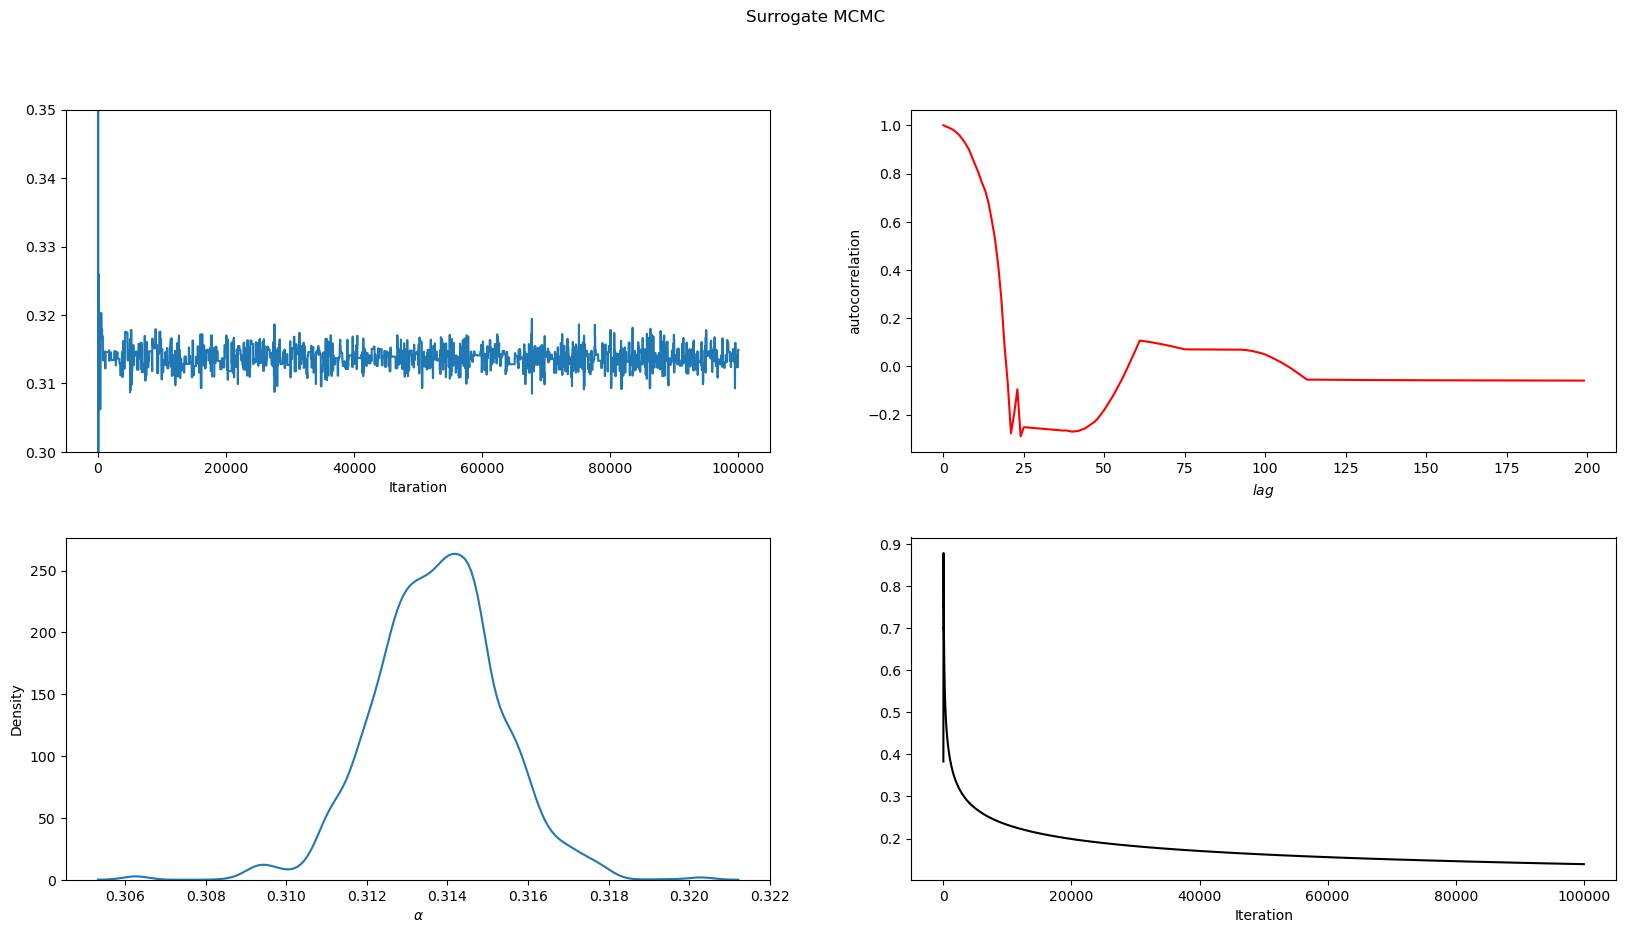

In [37]:
import seaborn as sns

fig = plt.figure(figsize=(20,10))
plt.suptitle("Surrogate MCMC")
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp)
plt.xlabel("Itaration")
plt.ylim(0.3,0.35)

plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
#plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
#plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
sns.kdeplot(alpha_samp[200:],bw_adjust=2)
plt.xlabel(r"$\alpha$")
#plt.xlim(0.3,0.32)

plt.subplot(2, 2, 4)
plt.plot(dt_tracker,color = "black")
plt.xlabel("Iteration")

Text(0.5, 0, 'Iteration')

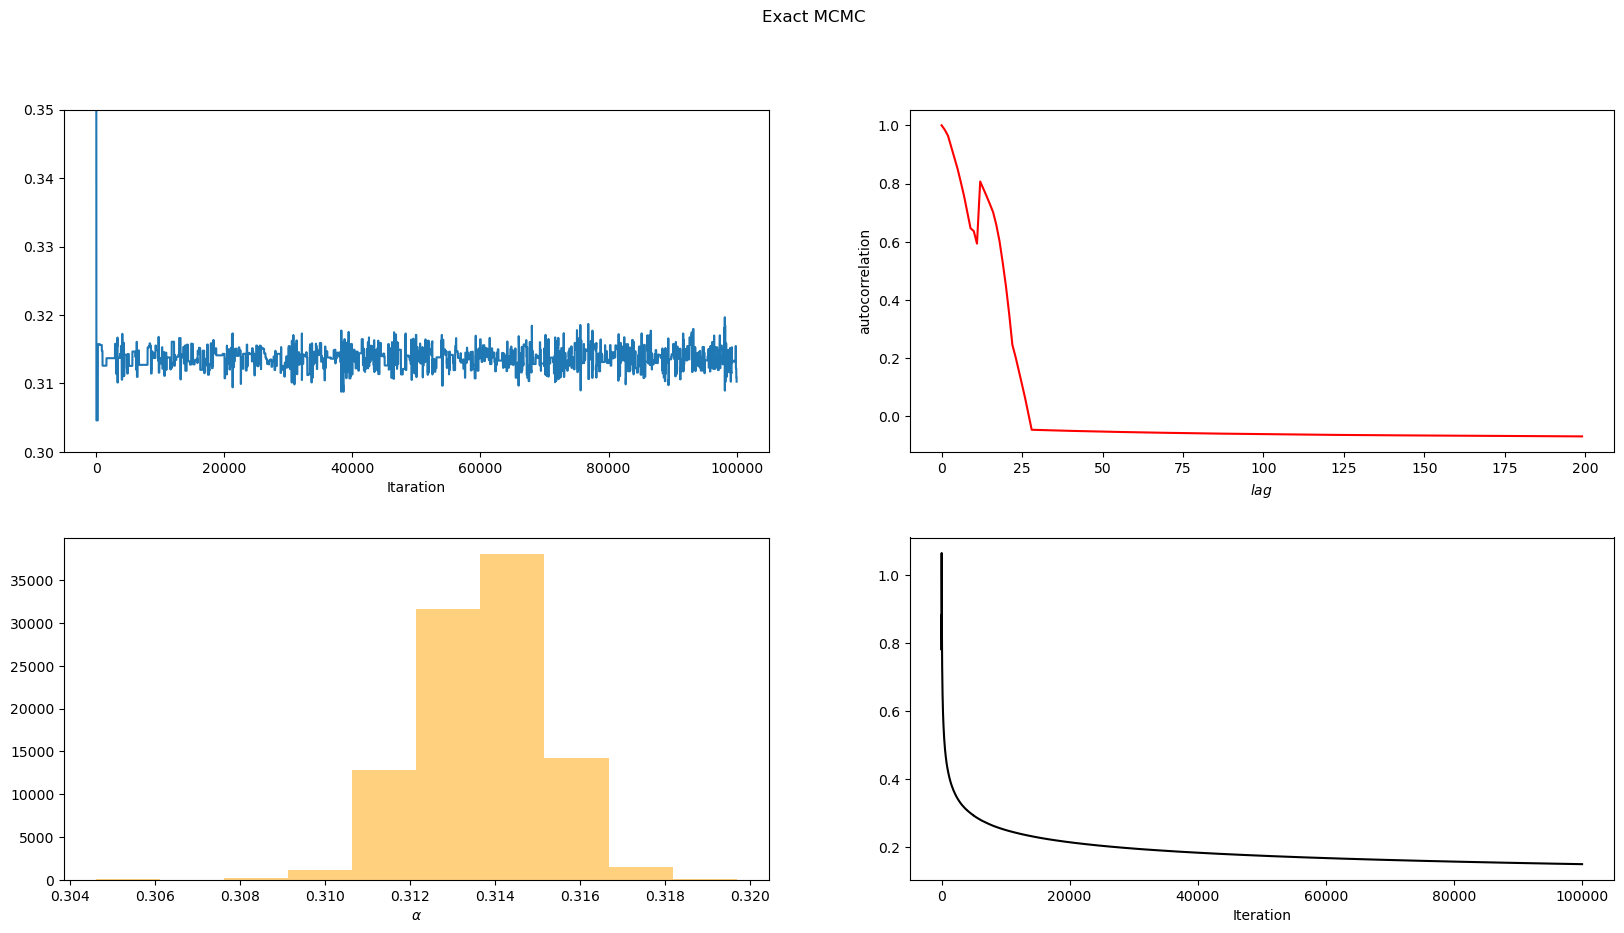

In [197]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Exact MCMC")

plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp_true)
plt.xlabel("Itaration")
plt.ylim(0.3,0.35)


plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp_true,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
plt.hist(alpha_samp_true[200:],color = "orange",alpha = 0.5)
plt.xlabel(r"$\alpha$")

plt.subplot(2, 2, 4)
plt.plot(dt_tracker_true,color = "black")
plt.xlabel("Iteration")